# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'lab2data/train.p'
testing_file = 'lab2data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Set flags for feature engineering.  This will prevent you from skipping an important steps.
is_features_yuv = False
is_features_y_normal = False
is_labels_encod = False
is_labels_float32 = False
has_new_jittered_datasets = False
has_split_jittered_datasets = False
has_pickled_split_datasets = False


In [2]:
### To start off let's do a basic data summary.
# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
classes = {}
for labelinTraining in y_train:
    classes[labelinTraining] = classes.get(labelinTraining, 0) + 1
n_classes = len(list(classes))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
#importing some useful packages for plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#import sklearn functions for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

#import pandas for csv file import
#NOTE: install pandas in your environment!
#conda install pandas
import pandas as pd

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# get the label description from the CSV file.
classLabelList = pd.read_csv('signnames.csv')

# Analyze Max and Min sizes (number of pixels) of the original image
sizeStats = pd.DataFrame(train['sizes'])
print("Sizes Stats:")
print(sizeStats.describe())

originalSizes = {}
mostCommonCount = 0
mostCommonSize = 0
for i in range(len(train['sizes'])):
    # for each size
    sizes = train['sizes'][i]
    
    # create a pixel hash
    numpixelsStr = str(int(sizes[0])*int(sizes[1]))
    
    # try to see if there is a hash hit
    sizeInstance = originalSizes.get(numpixelsStr, {'count': 0})
    
    # add to the count
    count = sizeInstance['count'] + 1
    
    # put in the last Index
    originalSizes[numpixelsStr] = {'lastIdx':i, 'count': count, 'size':sizes}
    
    # update most common size
    if count > mostCommonCount:
        mostCommonCount = count
        mostCommonSize = originalSizes[numpixelsStr]
    
# get the list of sizes and sort them
sortedSizes = np.array(list(originalSizes.keys()), np.int32)
sortedSizes.sort()

# get the unique number of original picture sizes and the min and max last instance
n_sizes = len(sortedSizes)
minSize = sortedSizes[0]
maxSize = sortedSizes[n_sizes-1]

# print the stats
print("\nNumber of unique original sizes in training set: ", n_sizes)


Sizes Stats:
                  0             1
count  39209.000000  39209.000000
mean      50.328930     50.835880
std       23.115423     24.306933
min       25.000000     25.000000
25%       35.000000     35.000000
50%       43.000000     43.000000
75%       58.000000     58.000000
max      225.000000    243.000000

Number of unique original sizes in training set:  2034


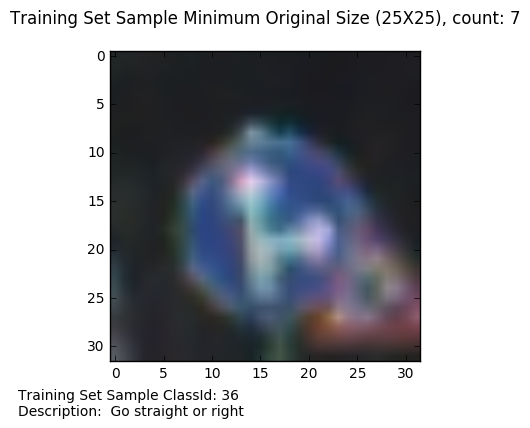

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# draw the min size picture
size = originalSizes[str(minSize)]['size']
count = originalSizes[str(minSize)]['count']
index = originalSizes[str(minSize)]['lastIdx']
classId = train['labels'][index]
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Training Set Sample ClassId: %d\nDescription:  %s'%(classId,description))
plt.title('Training Set Sample Minimum Original Size (%dX%d), count: %d\n'%(size[0], size[1],count))
plt.imshow(X_train[index])



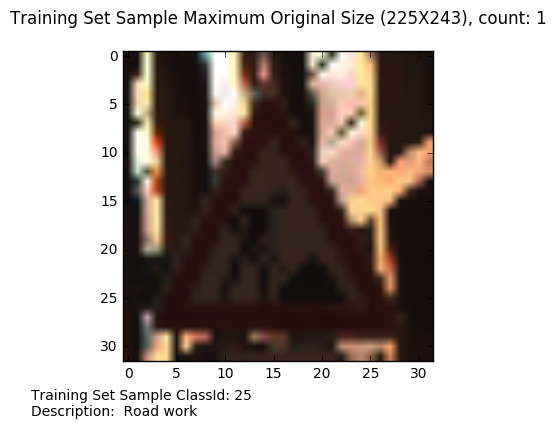

In [6]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# draw the max size picture
size = originalSizes[str(maxSize)]['size']
count = originalSizes[str(maxSize)]['count']
index = originalSizes[str(maxSize)]['lastIdx']
classId = train['labels'][index]
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Training Set Sample ClassId: %d\nDescription:  %s'%(classId,description))
plt.title('Training Set Sample Maximum Original Size (%dX%d), count: %d\n'%(size[0], size[1],count))
plt.imshow(X_train[index])


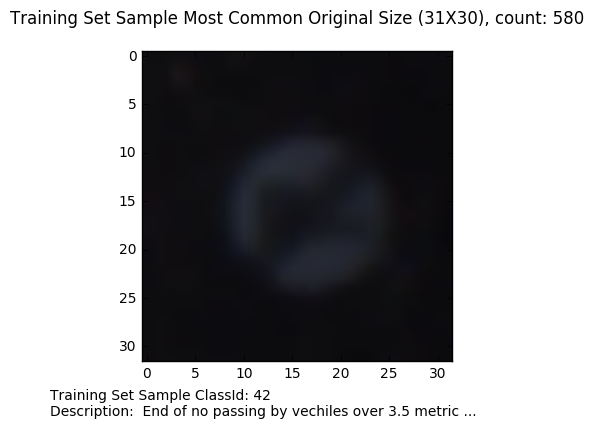

In [7]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# draw the max size picture
size = mostCommonSize['size']
count = mostCommonSize['count']
index = mostCommonSize['lastIdx']
classId = train['labels'][index]
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Training Set Sample ClassId: %d\nDescription:  %s'%(classId,description))
plt.title('Training Set Sample Most Common Original Size (%dX%d), count: %d\n'%(size[0], size[1],count))
plt.imshow(X_train[index])


In [8]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# get stats for the labels
labelsStats = pd.DataFrame(y_train)
print("Labels Stats:")
print(labelsStats.describe())

labelsInfo = {}
mostCommonCount = 0
mostCommonLabel = 0
for i in range(len(y_train)):
    # for each label
    label = str(y_train[i])
    
    # try to see if there is a hash hit
    labelInstance = labelsInfo.get(label, {'count': 0})
    
    # add to the count
    count = labelInstance['count'] + 1
    
    # put in the last Index
    labelsInfo[label] = {'lastIdx':i, 'count': count, 'label':int(label)}
    
    # update most common size
    if count > mostCommonCount:
        mostCommonCount = count
        mostCommonSize = labelsInfo[label]
    
# get the list of counts and sort them
sortedLabels = list(labelsInfo.keys())

def compare_count(label):
    return labelsInfo[label]['count']

sortedLabels.sort(key=compare_count)

# get the unique number of original picture sizes and the min and max last instance
n_labels = len(sortedLabels)
minLabel = sortedLabels[0]
maxLabel = sortedLabels[n_labels-1]


# print the stats
print("\nNumber of unique labels in training set: ", n_labels)
print("\nDistribution of training set labels:")
for i in range(n_labels):
    classId = labelsInfo[str(i)]['label']
    index = labelsInfo[str(i)]['lastIdx']
    count = labelsInfo[str(i)]['count']
    description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
    print("Training Set count: {0:4d}  ClassId: {1:02d}  Description: {2}".format(count, classId, description))


Labels Stats:
                  0
count  39209.000000
mean      15.788390
std       12.013238
min        0.000000
25%        5.000000
50%       12.000000
75%       25.000000
max       42.000000

Number of unique labels in training set:  43

Distribution of training set labels:
Training Set count:  210  ClassId: 00  Description: Speed limit (20km/h)
Training Set count: 2220  ClassId: 01  Description: Speed limit (30km/h)
Training Set count: 2250  ClassId: 02  Description: Speed limit (50km/h)
Training Set count: 1410  ClassId: 03  Description: Speed limit (60km/h)
Training Set count: 1980  ClassId: 04  Description: Speed limit (70km/h)
Training Set count: 1860  ClassId: 05  Description: Speed limit (80km/h)
Training Set count:  420  ClassId: 06  Description: End of speed limit (80km/h)
Training Set count: 1440  ClassId: 07  Description: Speed limit (100km/h)
Training Set count: 1410  ClassId: 08  Description: Speed limit (120km/h)
Training Set count: 1470  ClassId: 09  Description: No p

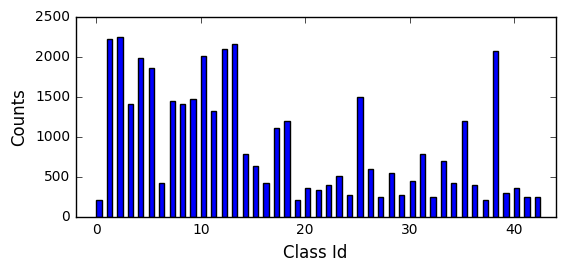

In [9]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Plot bar graph of class id count distribution
x = range(0, n_labels)
y = [labelsInfo[str(n)]['count'] for n in x]
fg = plt.figure()
ax1 = fg.add_axes((.1,.4,.8,.5))
ax1.bar(x,y,0.5)
plt.xlim((-2.0, 44))
plt.ylabel("Counts", fontsize = 12)
plt.xlabel("Class Id", fontsize = 12)
plt.show()


In [10]:
# print the stats
print("\nDistribution of training set labels in sorted count order:")
for i in range(n_labels):
    classId = labelsInfo[str(sortedLabels[i])]['label']
    index = labelsInfo[str(sortedLabels[i])]['lastIdx']
    count = labelsInfo[str(sortedLabels[i])]['count']
    description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
    print("Training Set count: {0:4d}  ClassId: {1:02d}  Description: {2}".format(count, classId, description))



Distribution of training set labels in sorted count order:
Training Set count:  210  ClassId: 37  Description: Go straight or left
Training Set count:  210  ClassId: 00  Description: Speed limit (20km/h)
Training Set count:  210  ClassId: 19  Description: Dangerous curve to the left
Training Set count:  240  ClassId: 41  Description: End of no passing
Training Set count:  240  ClassId: 32  Description: End of all speed and passing limits
Training Set count:  240  ClassId: 27  Description: Pedestrians
Training Set count:  240  ClassId: 42  Description: End of no passing by vechiles over 3.5 metric ...
Training Set count:  270  ClassId: 24  Description: Road narrows on the right
Training Set count:  270  ClassId: 29  Description: Bicycles crossing
Training Set count:  300  ClassId: 39  Description: Keep left
Training Set count:  330  ClassId: 21  Description: Double curve
Training Set count:  360  ClassId: 40  Description: Roundabout mandatory
Training Set count:  360  ClassId: 20  Desc

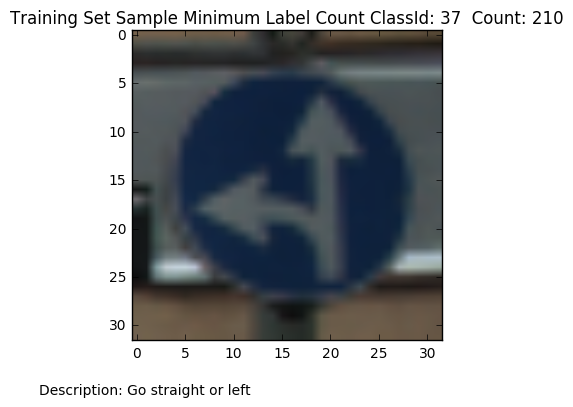

In [11]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# list minimium count for class id and draw a sample picture.
classId = labelsInfo[str(minLabel)]['label']
index = labelsInfo[str(minLabel)]['lastIdx']
count = labelsInfo[str(minLabel)]['count']
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s'%(description))
plt.title('Training Set Sample Minimum Label Count ClassId: %d  Count: %d'%(classId,count))
plt.imshow(X_train[index])

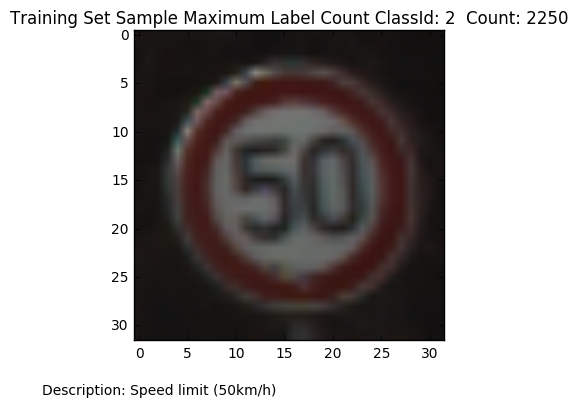

In [12]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# list maximium count for class id and draw a sample picture.
classId = labelsInfo[str(maxLabel)]['label']
index = labelsInfo[str(maxLabel)]['lastIdx']
count = labelsInfo[str(maxLabel)]['count']
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s'%(description))
plt.title('Training Set Sample Maximum Label Count ClassId: %d  Count: %d'%(classId,count))
plt.imshow(X_train[index])

In [13]:
# It seems that the 'sizes' (width, height) and 'coords' (x1, y1, x2, y2) features have the same values?
# Looks like we cannot get any real information from the 'coords' feature.
allsame = True
for i in range(n_train):
    if not (train['sizes'][i].all() == train['coords'][i].all()):
        allsame = False
if allsame:
    print("train['sizes'] == train['coords']!!!\nIgnoring 'coords' feature in train dataset.\n")

allsame = True
for i in range(n_test):
    if not (test['sizes'][i].all() == test['coords'][i].all()):
        allsame = False
if allsame:
    print("test['sizes'] == test['coords']!!!\nIgnoring 'coords' feature in test dataset.\n")



train['sizes'] == train['coords']!!!
Ignoring 'coords' feature in train dataset.

test['sizes'] == test['coords']!!!
Ignoring 'coords' feature in test dataset.



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Features are now converted YUV!
X_train image shape:  (32, 32, 3)  of  <class 'numpy.uint8'>


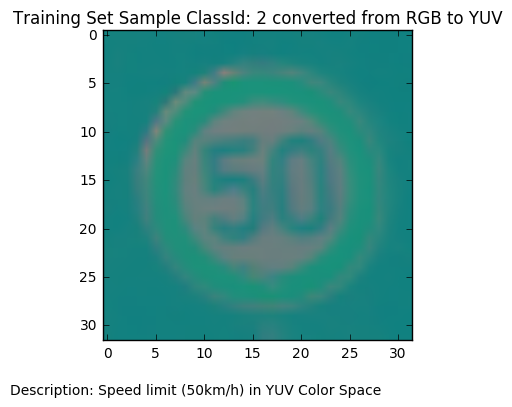

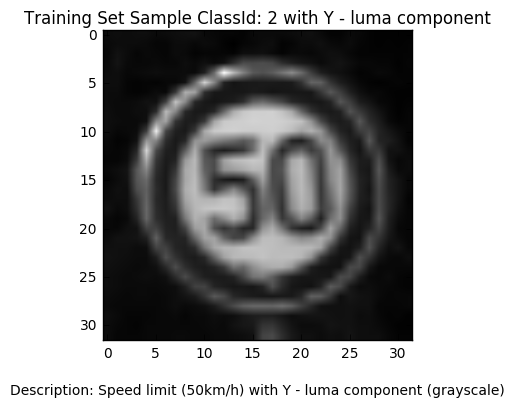

In [14]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
###
### Step 1:
### We need to condition the training and testing data.  We need to convert the color image to grey scale since
### RGB features in the traffic sign will not contribute to its classification and recognition.  We will use
### OpenCV to do the conversion as we did in the earlier Lane Line Project 1 to reduce the size of the features
### so as to allow the Stochastic Gradient Descent Machine Learning algorithm to process more relivent data to
### learn faster.  In referencing the article: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf,
### page 2, section III. EXPERIMENTS, subsection A. Data Preparation, item 2) Pre-processing, we find 
### converting the feature RGB color space to YUV seems to improve classification and recognition, and we will
### follow this path as well.  Since our training and test features are already at 32x32 resolution, we just
### need to do the conversion to YUV color space in this step.

def RGB2YUV(image_data):
    yuv_image_data = []
    for i in range(len(image_data)):
        yuv_image_data.append(cv2.cvtColor(image_data[i], cv2.COLOR_RGB2YUV))
    return np.array(yuv_image_data)

if is_features_yuv:
    print('Nothing done.  Features are already in YUV!')
else:
    X_train = RGB2YUV(X_train)
    y_train = np.copy(y_train)
    X_test = RGB2YUV(X_test)
    y_test = np.copy(y_test)
    is_features_yuv = True
    print('Features are now converted YUV!')

# list maximium count for class id and draw a sample picture.
print('X_train image shape: ', X_train[index].shape, " of ", type(X_train[index][0][0][0]))
classId = labelsInfo[str(maxLabel)]['label']
index = labelsInfo[str(maxLabel)]['lastIdx']
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s in YUV Color Space'%(description))
plt.title('Training Set Sample ClassId: %d converted from RGB to YUV'%(classId))
plt.imshow(X_train[index])

yuv = cv2.split(X_train[index])
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s with Y - luma component (grayscale)'%(description))
plt.title('Training Set Sample ClassId: %d with Y - luma component'%(classId))
plt.imshow(yuv[0], cmap='gray')


Features Y are now normalized and converted to float32!
X_train image shape:  (32, 32, 3)  of  <class 'numpy.float32'>


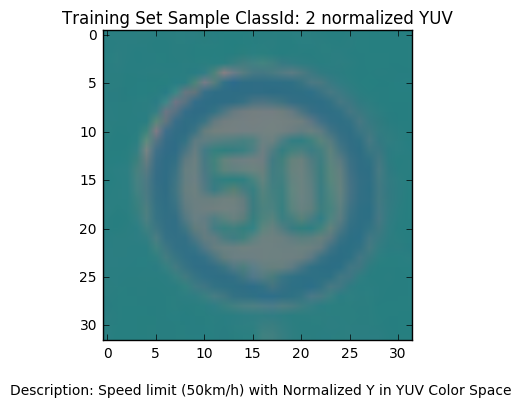

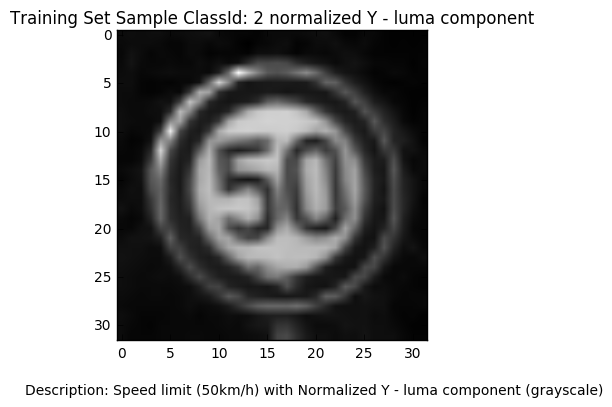

In [15]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
###
### Step 2:
### We will implement the Min-Max scaling function and apply it to the Y in the UV color space as described in
### in the article: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf, page 2, section III.
### EXPERIMENTS, subsection A. Data Preparation, item 2) Pre-processing.  We will apply this to images we
### converted in step 1.
###
### This is needed as we did in the TensorFlow Neural Network Lab assignment to process the image into a
### well conditioned features so we are centered on a zero mean with equal variance to make it easy for
### our neural network to perform Gradient Descent faster to train its weights and biases to the given labels.
### We will also convert the features from uint8 to float32 to make it easier for GPUs to process the data
### Using their thousands of multi-cores parallel processing units in a CUDA enabled Deep Learning system.

assert is_features_yuv

def normalize_Y_in_YUV(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    y_min = 0
    y_max = 255
    yuv_image_data = []

    for i in range(len(image_data)):
        yuv = cv2.split(image_data[i])  
        y = np.array(yuv[0], np.float32)
        y = a + ( ( (y - y_min)*(b - a) )/( y_max - y_min ) )
        u = np.array(yuv[1], np.float32)
        v = np.array(yuv[2], np.float32)
        yuv = np.dstack((y, u, v))
        yuv_image_data.append(yuv)
    return np.array(yuv_image_data)

if is_features_y_normal:
    print('Nothing done.  Features Y are already normalized and converted to float32!')
else:
    X_train = normalize_Y_in_YUV(X_train)
    X_test = normalize_Y_in_YUV(X_test)
    is_features_y_normal = True
    print('Features Y are now normalized and converted to float32!')

# list maximium count for class id and draw a sample picture.
print('X_train image shape: ', X_train[index].shape, " of ", type(X_train[index][0][0][0]))
classId = labelsInfo[str(maxLabel)]['label']
index = labelsInfo[str(maxLabel)]['lastIdx']
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s with Normalized Y in YUV Color Space'%(description))
plt.title('Training Set Sample ClassId: %d normalized YUV'%(classId))
plt.imshow(X_train[index])

yuv = cv2.split(X_train[index])
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s with Normalized Y - luma component (grayscale)'%(description))
plt.title('Training Set Sample ClassId: %d normalized Y - luma component'%(classId))
plt.imshow(yuv[0], cmap='gray')


In [16]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
###
### Step 3:
### We will apply One-Hot Encoding to our numeric traffic labels.
### This is a way to represent our labels mathematically so that we have a vector that contains as many values
### as we have classes.  The value that we want to set for the correct class is set to 1 while all others are
### set to 0.

assert is_features_y_normal

if is_labels_encod:
    print('Nothing done.  Labels are already One-Hot encoded!')
else:
    encoder = LabelBinarizer()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)
    is_labels_encod = True
    print('Labels are now One-Hot encoded!')


Labels are now One-Hot encoded!


In [17]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
###
### Step 4:
### We will change our One-Hot Encoded labels to float32 so as to allow them to be multiplied against
### the features in Tensorflow using the thousands of multi-cores parallel processing units in a CUDA
### enabled Deep Learning system.

assert is_labels_encod

if is_labels_float32:
    print('Nothing done!  Labels are already float32!')
else:
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    is_labels_float32 = True
    print('Labels are now float32!')

Labels are now float32!


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

Generating dataset iteration: 1...
Generating dataset iteration: 2...
Generating dataset iteration: 3...
3 new jitter datasets generated and added to training and testing sets!
Original dataset sizes, training set:  39209  testing set:  12630
New generated dataset sizes, training set:  156836  testing set:  50520


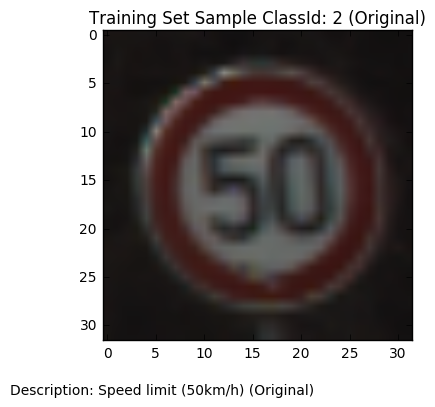

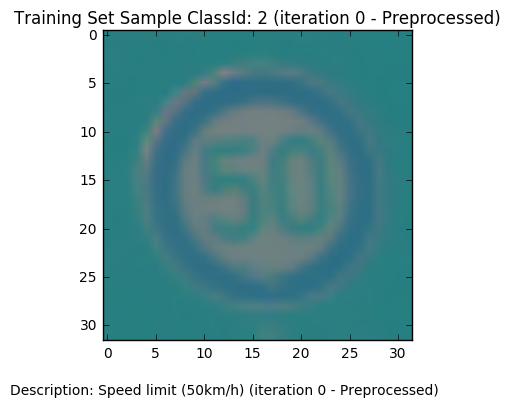

In [18]:
### Generate data additional (if you want to!)
### Feel free to use as many code cells as needed.
###
### In referencing the article: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf,
### page 2, section III. EXPERIMENTS, subsection A. Data Preparation, item 2) Pre-processing, we find 
### that if we generate a "Jittered dataset" and add it to our original dataset, it will drop our validation
### error from around 1.31% to 1.08%.  We can follow the same procedure as described in this section, and
### generate additional 5X samples by randomly perturbed in position ([-2,2] pixels),
### in scale ([.9,1.1] ratio) and rotation ([-15,+15] degrees).  As described in the reference:
### "When a dataset does not naturally contain those deformations, adding them synthetically will yield
###  more robust learning to potential deformations in the test set."

### jitterX specifies number of new jitter sets to generate.
### NOTE: OSX has an issue with saving pickle files larger than 2gb, so use smaller jitterX here for OSX!

jitterX = 3

assert is_features_yuv
assert is_features_y_normal
assert is_labels_encod
assert is_labels_float32

import random

# function to shift images x or y offsets
def shiftxy(image, xoffset, yoffset):
    rows,cols, depth = image.shape
    M = np.float32([[1,0,xoffset],[0,1,yoffset]])
    res = cv2.warpAffine(image,M,(cols,rows))
    assert (res.shape[0] == 32)
    assert (res.shape[1] == 32)
    return res
    
# function to rotate images by given degrees
def rotate(image, degree):
    rows, cols, depth = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degree, 1)
    res = cv2.warpAffine(image, M, (cols,rows))
    assert (res.shape[0] == 32)
    assert (res.shape[1] == 32)
    return res
    
# function to resize the image
def scale(image, ratio):
    rows, cols, depth = image.shape
    newrows = int(ratio*rows)
    newcols = int(ratio*cols)
    res = cv2.resize(image, (newrows, newcols), interpolation=cv2.INTER_AREA)
    if newrows*newcols > 1024:
        # image is larger than 32x32, randomly crop the image back to 32x32
        xoffset = (newcols-32)-int(random.random()*float(newcols-32))
        yoffset = (newrows-32)-int(random.random()*float(newrows-32))
        cropped = res[xoffset:xoffset+32, yoffset:yoffset+32]
        res = cropped
    else:
        # image is smaller than before, randomly insert it into a 32x32 canvas
        if newrows*newcols < 1024:
            tmpimage = np.copy(image)*0.0
            xoffset = (32-newcols)-int(random.random()*float(32-newcols))
            yoffset = (32-newrows)-int(random.random()*float(32-newrows))
            tmpimage[xoffset:newrows+xoffset, yoffset:newcols+yoffset] = res
            res = tmpimage
    assert (res.shape[0] == 32)
    assert (res.shape[1] == 32)
    return res

# function to generate a new set of training or test dataset by building a jittered dataset.
def generateNewSet(image_data):
    new_image_data = np.copy(image_data)
    for i in range(len(new_image_data)):
        x = int(random.random() * 4) - 2
        y = int(random.random() * 4) - 2
        degree = int(random.random()*30.0)-15
        ratio = random.random()*0.2 + 0.9
        new_image_data[i] = scale(rotate(shiftxy(image_data[i],x,y),degree),ratio)
    return normalize_Y_in_YUV(RGB2YUV(new_image_data))

if has_new_jittered_datasets:
    print('Nothing done!  {} new jitter datasets have already been generated!'.format(jitterX))
else:
    tmp_y_train = np.copy(y_train)
    tmp_y_test = np.copy(y_test)
    for x in range(jitterX):
        i = x+1
        print('Generating dataset iteration: {}...'.format(i))
        X_train = np.append(X_train, generateNewSet(train['features']), axis=0)
        y_train = np.append(y_train, tmp_y_train, axis=0)
        X_test = np.append(X_test, generateNewSet(test['features']), axis=0)
        y_test = np.append(y_test, tmp_y_test, axis=0)
    has_new_jittered_datasets = True
    print("{} new jitter datasets generated and added to training and testing sets!".format(jitterX))

print("Original dataset sizes, training set: ", len(train['features']), " testing set: ", len(test['features']))
print("New generated dataset sizes, training set: ", len(X_train), " testing set: ", len(X_test))

### Generate data additional (if you want to!)
### Feel free to use as many code cells as needed.
###
# list maximium count for class id and draw a sample picture.
classId = labelsInfo[str(maxLabel)]['label']
indexoffset = labelsInfo[str(maxLabel)]['lastIdx']
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s (Original)'%(description))
plt.title('Training Set Sample ClassId: %d (Original)'%(classId))
plt.imshow(train['features'][indexoffset])

for i in range(1):
    index = n_train*i+indexoffset
    fg = plt.figure()
    fg.text(0.1,-0.01,'Description: %s (iteration %d - Preprocessed)'%(description, i))
    plt.title('Training Set Sample ClassId: %d (iteration %d - Preprocessed)'%(classId, i))
    plt.imshow(X_train[index])
    yuv = cv2.split(X_train[index])

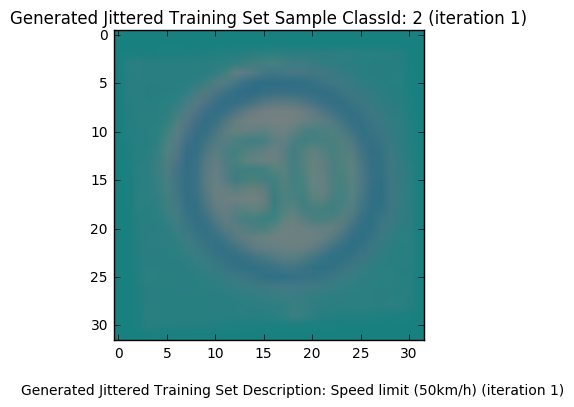

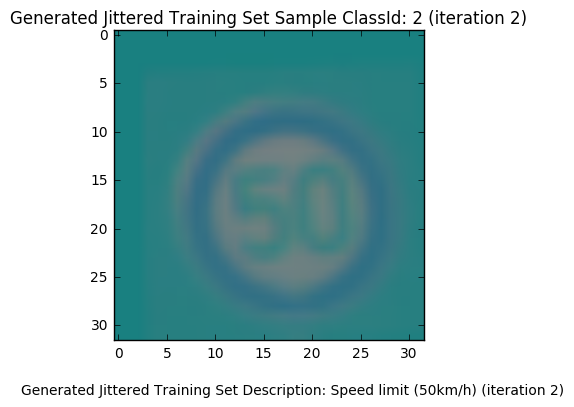

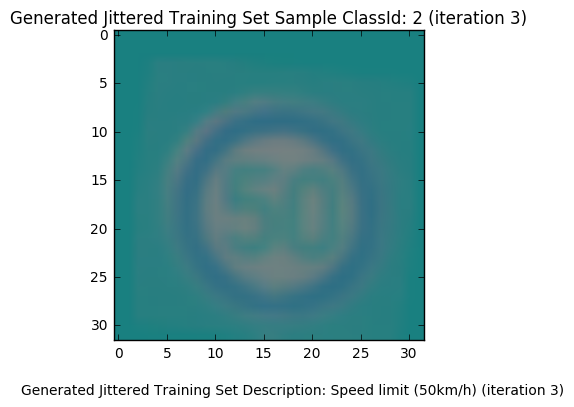

In [19]:
### Generate data additional (if you want to!)
### Feel free to use as many code cells as needed.
### Visualize the new Jittered Dataset

for n in range(jitterX):
    i = n+1
    index = n_train*i+indexoffset
    fg = plt.figure()
    fg.text(0.1,-0.01,'Generated Jittered Training Set Description: %s (iteration %d)'%(description, i))
    plt.title('Generated Jittered Training Set Sample ClassId: %d (iteration %d)'%(classId, i))
    plt.imshow(X_train[index])
    yuv = cv2.split(X_train[index])

In [20]:
### Generate data additional (if you want to!)
### Visualize the new Jittered Dataset
### get stats for the labels

labelsStats = pd.DataFrame(y_train)
print("Labels Stats:")
print(labelsStats.describe())

labelsInfo = {}
mostCommonCount = 0
mostCommonLabel = 0
for i in range(len(y_train)):
    # for each label
    label = str(train['labels'][i%n_train])
    
    # try to see if there is a hash hit
    labelInstance = labelsInfo.get(label, {'count': 0})
    
    # add to the count
    count = labelInstance['count'] + 1
    
    # put in the last Index
    labelsInfo[label] = {'lastIdx':i, 'count': count, 'label':int(label)}
    
    # update most common size
    if count > mostCommonCount:
        mostCommonCount = count
        mostCommonSize = labelsInfo[label]
    
# get the list of counts and sort them
sortedLabels = list(labelsInfo.keys())

def compare_count(label):
    return labelsInfo[label]['count']

sortedLabels.sort(key=compare_count)

# get the unique number of original picture sizes and the min and max last instance
n_labels = len(sortedLabels)
minLabel = sortedLabels[0]
maxLabel = sortedLabels[n_labels-1]


# print the stats
print("\nNumber of unique labels in training set: ", n_labels)
print("\nDistribution of training set labels:")
for i in range(n_labels):
    index = labelsInfo[str(i)]['lastIdx']
    classId = train['labels'][index%n_train]
    count = labelsInfo[str(i)]['count']
    description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
    print("Training Set count: {0:6d}  ClassId: {1:02d}  Description: {2}".format(count, classId, description))

Labels Stats:
                  0              1              2              3   \
count  156836.000000  156836.000000  156836.000000  156836.000000   
mean        0.005356       0.056620       0.057385       0.035961   
std         0.072988       0.231115       0.232577       0.186194   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

                  4              5              6              7   \
count  156836.000000  156836.000000  156836.000000  156836.000000   
mean        0.050499       0.047438       0.010712       0.036726   
std         0.218972       0.212575       0.102942       0.188090   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.00000

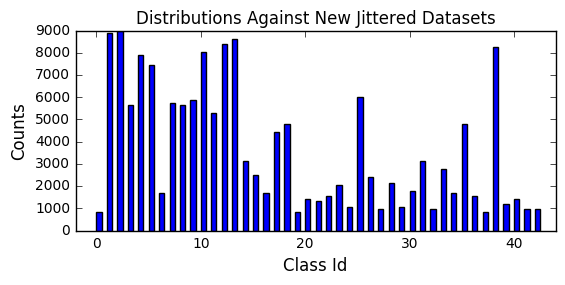

In [21]:
### Generate data additional (if you want to!)
# Plot bar graph of class id count distribution with the additional jittered datasets
x = range(0, n_labels)
y = [labelsInfo[str(n)]['count'] for n in x]
fg = plt.figure()
ax1 = fg.add_axes((.1,.4,.8,.5))
ax1.bar(x,y,0.5)
plt.xlim((-2.0, 44))
plt.ylabel("Counts", fontsize = 12)
plt.xlabel("Class Id", fontsize = 12)
plt.title("Distributions Against New Jittered Datasets")
plt.show()

In [22]:
### Split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
###
### Get randomized datasets for training and validation
assert has_new_jittered_datasets

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.05,
    random_state=890231267)


print('Training features and labels randomized and split.')
print("Original dataset sizes, training set: ", len(train['features']), " testing set: ", len(test['features']))
print("New dataset sizes, training set: ", len(X_train), "validating set: ", len(X_validate), " testing set: ", len(X_test))
has_split_jittered_datasets = True


Training features and labels randomized and split.
Original dataset sizes, training set:  39209  testing set:  12630
New dataset sizes, training set:  148994 validating set:  7842  testing set:  50520


In [23]:
# Save the data for easy access
import os

assert has_split_jittered_datasets

pickle_file1 = 'lab2data/triffic_signs_with_jitters1.p'
pickle_file2 = 'lab2data/triffic_signs_with_jitters2.p'
pickle_file3 = 'lab2data/triffic_signs_with_jitters3.p'
if os.path.isfile(pickle_file1):
    print('Nothing Done!  Data already cached in pickle files: {} {} and {}.'.format(pickle_file1, pickle_file2, pickle_file3))
    has_pickled_split_datasets = True
else:
    has_pickled_split_datasets = False
    print('Saving data to pickle files...\n')
    try:
        # need to use literal filename otherwise get 'OSError: [Errno 22] Invalid argument' error.
        with open(pickle_file3, 'w+b') as pfile3:
            print('Saving data to pickle file: {} ...\n'.format(pickle_file3))
            pickle_file = pickle_file3
            pickle.dump({'X_test': X_test, 'y_test': y_test}, pfile3, pickle.HIGHEST_PROTOCOL)
        with open(pickle_file2, 'w+b') as pfile2:
            print('Saving data to pickle file: {} ...\n'.format(pickle_file2))
            pickle_file = pickle_file2
            pickle.dump({'X_validate': X_validate, 'y_validate': y_validate}, pfile2, pickle.HIGHEST_PROTOCOL)
        with open(pickle_file1, 'w+b') as pfile1:
            print('Saving data to pickle file: {} ...\n'.format(pickle_file1))
            pickle_file = pickle_file3
            pickle.dump({'X_train': X_train, 'y_train': y_train}, pfile1, pickle.HIGHEST_PROTOCOL)
        has_pickled_split_datasets = True
        print('Data cached in pickle files: {} {} and {}.'.format(pickle_file1, pickle_file2, pickle_file3))
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise


Saving data to pickle files...

Saving data to pickle file: lab2data/triffic_signs_with_jitters3.p ...

Saving data to pickle file: lab2data/triffic_signs_with_jitters2.p ...

Saving data to pickle file: lab2data/triffic_signs_with_jitters1.p ...

Data cached in pickle files: lab2data/triffic_signs_with_jitters1.p lab2data/triffic_signs_with_jitters2.p and lab2data/triffic_signs_with_jitters3.p.


# Checkpoint
All our progress is now saved to three pickle files.  If we need to leave and comeback, we no longer have to start from the beginning.  Just run the code block below and it will load all the data and modules required to proceed.

In [3]:
#
# Load the modules
import pickle
import math
import tensorflow as tf
from tqdm import tqdm

#importing some useful packages for plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#import sklearn functions for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

#import pandas for csv file import
#NOTE: install pandas in your environment!
#conda install pandas
import pandas as pd

# Reload the data
class_file = 'signnames.csv'
pickle_file1 = 'lab2data/triffic_signs_with_jitters1.p'
pickle_file2 = 'lab2data/triffic_signs_with_jitters2.p'
pickle_file3 = 'lab2data/triffic_signs_with_jitters3.p'
training_file = 'lab2data/train.p'
testing_file = 'lab2data/test.p'

classLabelList = pd.read_csv(class_file)
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

with open(pickle_file1, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['X_train']
    y_train = pickle_data['y_train']
    del pickle_data
    
with open(pickle_file2, 'rb') as f:
    pickle_data = pickle.load(f)
    X_validate = pickle_data['X_validate']
    y_validate = pickle_data['y_validate']
    del pickle_data

with open(pickle_file3, 'rb') as f:
    pickle_data = pickle.load(f)
    X_test = pickle_data['X_test']
    y_test = pickle_data['y_test']
    del pickle_data

# Set flags for load states.
is_features_yuv = True
is_features_y_normal = True
is_labels_encod = True
is_labels_float32 = True
has_new_jittered_datasets = True
has_split_jittered_datasets = True
has_pickled_split_datasets = True

### To start off let's do a basic data summary.
# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
classes = {}
for labelinTraining in train['labels']:
    classes[labelinTraining] = classes.get(labelinTraining, 0) + 1
n_classes = len(list(classes))

print('Data, states and modules loaded.')

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Data, states and modules loaded.
Number of training examples = 148994
Number of testing examples = 50520
Image data shape = (32, 32, 3)
Number of classes = 43


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [42]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
### We will build a deep mult-layer, multi-scaled convolutional network.  Based on both:
###    1. http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
###    2. https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html
### deep multi-layer, multi-scaled convolutional networks or (ConvNets) are great at classifying
### pictures of traffic signs and other picture recognition, such as pictures from the MNIST database.
### In particular, www.tensorflow.org has examples and tutorials on how to set up such a network for
### performing just this classification.  We will start with their example and use some of the insights
### gleamed from the yann.lecum.com article to set up our initial architecture.
### Since we are in a Jupyter interactive session, we will follow the www.tensorflow.com's MNIST PRO tutorial
### and use an InteractiveSession to access the and build a computation graph as we build our ConvNet for
### traffic sign classification and recognition.

sess = tf.InteractiveSession()

### First we start building a computational graph by creating nodes for the input images and target output
### classes.  We will define an 'image' placeholder for a 2d tensor of 3 floating point numbers (32,32,3) = 3072.
### The 'None' value in shape indicates that the first dimension, which is the batch size, can be any
### arbitary size of our chosing.

rows, cols, depth = image_shape
imagesize = rows*cols*depth
images = tf.placeholder(tf.float32, shape=[None, rows*cols*depth])

### We will define a oneHot placeholder for a 2d tensor where each row is a one-hot 43-dimensional vector
### indicating which traffic sign class the corresponding image belongs to.

oneHotLabels = tf.placeholder(tf.float32, shape=[None, n_classes])


### Now we need to define the weights W and biases b for our model using TensorFlow's Variables.
### In TensorFlow, a Variable is a value that lives in its computational graph.  It can be used and
### even modified by the computation.  For ConvNets and Machine Learning in general, we define the
### model's parameters as Variables.  For our model, we have the following model parameters:
###
###    1. W = [ 32x32x3 image ] [ 43 classes ] or 3072x43 matrix
###    2. b = [ 43 oneHot ] or 43-dimensional vector for our traffic sign classes.
###
### These TensorFlow variable are defined below

W = tf.Variable(tf.truncated_normal((rows*cols*depth, n_classes)))
b = tf.Variable(tf.zeros(n_classes))

### Now that we defined our variables, lets initialize them to zero

sess.run(tf.initialize_all_variables())

### We now define our regress model with just one line for the linear regression
###
###    y = W(image) + b
###
### where y is our prediction,
###       W is our weight parameter
###       image is our input image placeholder
###       b is our biases parameter.

labels = tf.matmul(images, W) + b

### Determine if the predictions are correct

is_correct_prediction = tf.equal(tf.argmax(labels, 1), tf.argmax(oneHotLabels, 1))

### Calculate the accuracy of the predictions

accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))


### Now we need to need to feed back our prediction accuracy back into the ConvNet so that it can learn
### if its prediction are any good.  As we know before, the network will use Stochastic Gradient Descent
### to learn and correct its predictions to be more accurate.  We do this by defining the cross_entropy
### function.  The cross_entropy function will feed back the error score using softmax and reduce_mean
### with the correct classification of the image and the model's current prediction.  These functions will
### internally apply the softmax on the model's unnormalized model prediction and sums across all classes,
### and then take the average over these sums.

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, oneHotLabels))

### Now set up our Feed dicts for training, validation and testing.

train_feed_dict = {images: np.array([np.reshape(n, 3072) for n in X_train]), oneHotLabels: y_train}
validate_feed_dict = {images: np.array([np.reshape(n, 3072) for n in X_validate]), oneHotLabels: y_validate}
test_feed_dict = {images: np.array([np.reshape(n, 3072) for n in X_test]), oneHotLabels: y_test}

# Validation:

print("images._shape", images._shape)
print("labels._shape", labels._shape)
print("W._variable._shape", W._variable._shape)
print("b._variable._shape", b._variable._shape)


images._shape (?, 3072)
labels._shape (?, 43)
W._variable._shape (3072, 43)
b._variable._shape (43,)













Epoch  1/1: 100%|██████████| 149/149 [00:31<00:00, 13.49batches/s]


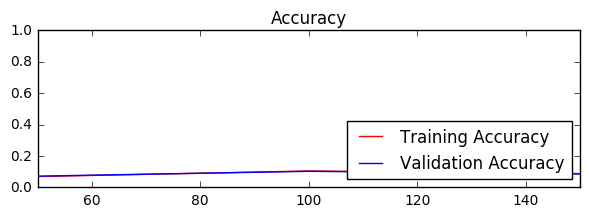

In [48]:
### Now that we defined our model and training loss function, its is time to train our model using
### TensorFlow Interactively!  Since we have already decided to use Stochastic Gradient Descent,
### we can use TensorFlow's builtin support for Stochastic Gradient Descent function:
###
###     train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
###
### The instruction to TensorFlow above is to add a new set of operations in the computation graph to
### compute gradients, parameter update steps, and apply the update steps to the parameters, and all
### in a single line!  Pretty neat!  The train_step that is passed back is actually a training object
### with batch training methods.  We will now start exercising this method and get an idea of how well
### we are purforming with a single layer tensor with a thousand training iterations.  Let's define
### some functions and parameters for each training configuration:

def next_batch(batch_size, trainingdict, batch_i):
    batch_count = int(math.ceil(len(trainingdict[images])/batch_size))
    
    # Get a batch of training features and labels
    batch_start = batch_i*batch_size
    batch_features = trainingdict[images][batch_start:(batch_start+batch_size)]
    batch_labels = trainingdict[oneHotLabels][batch_start:(batch_start+batch_size)] 

    # return batch dictionary
    return {images:batch_features , oneHotLabels: batch_labels}
    
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

def SingleLayerTraining(trainingdict, epochs, batch_size, learning_rate, log_batch_step):
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    batch_count = int(math.ceil(len(trainingdict[images])/batch_size))
    for epoch_i in range(epochs):
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # training cycle
        for batch_i in batches_pbar:
            
            # run the batch
            batchdict = next_batch(batch_size, trainingdict, batch_i)
            # print("batchdict: ", batchdict)
            train_step.run(feed_dict=batchdict)
            
            # log every log_batch_step times
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = sess.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = sess.run(accuracy, feed_dict=validate_feed_dict)
                
                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                # loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
                
        # Check accuracy against Validation data
        validation_accuracy = sess.run(accuracy, feed_dict=validate_feed_dict)

    #loss_plot = plt.subplot(211)
    #loss_plot.set_title('Loss')
    #loss_plot.plot(batches, loss_batch, 'g')
    #loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()

## List do 1 run of 1000 batch sizes with 0.01 learning rate and log every 50 batches
epochs = 1
batch_size = 1000
learning_rate = 0.01
log_batch_step = 50

SingleLayerTraining(train_feed_dict, epochs, batch_size, learning_rate, log_batch_step)



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.